# Amazon Reviews Sentiment Analysis

#### Introduction
- <b>Natural Language Processing (NLP):</b> The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more

- <b>Sentiment Analysis:</b> It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

In this notebook, we'll develop a Sentiment Analysis model to categorize a product' reviews as Positive or Negative.

### Importing Dependencies

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import re
from wordcloud import WordCloud

import spacy
from spacy.lang.en import English

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

## Importing dataset

In [14]:
# I removed the dataset from the code due to its size
# It can be downloaded from this link
# https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews
data = pd.read_csv("Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Inspect our dataset

In [7]:
data.shape

(568454, 10)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [9]:
# Calculate the sum of empty cells in each column
data.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [10]:
# Remove rows with empty columns
data.dropna(inplace= True)

data.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [120]:
# Filter dataset
products = data[['ProductId', 'Score', 'Text']]
products

,ProductId,Score,Text
0,B001E4KFG0,5,I have bought several of the Vitality canned d...
1,B00813GRG4,1,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,4,This is a confection that has been around a fe...
3,B000UA0QIQ,2,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,5,Great taffy at a great price. There was a wid...
...,...,...,...
568449,B001EO7N10,5,Great for sesame chicken..this is a good if no...
568450,B003S1WTCU,2,I'm disappointed with the flavor. The chocolat...
568451,B004I613EE,5,"These stars are small, so you can give 10-15 o..."
568452,B004I613EE,5,These are the BEST treats for training and rew...


#### What's the distribution of ratings

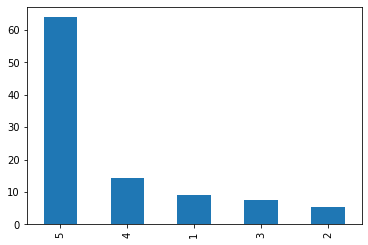

In [121]:
# Explore products rating distribution
rating_pct = products['Score'].value_counts()/len(products) * 100
rating_pct.plot.bar()
plt.show()


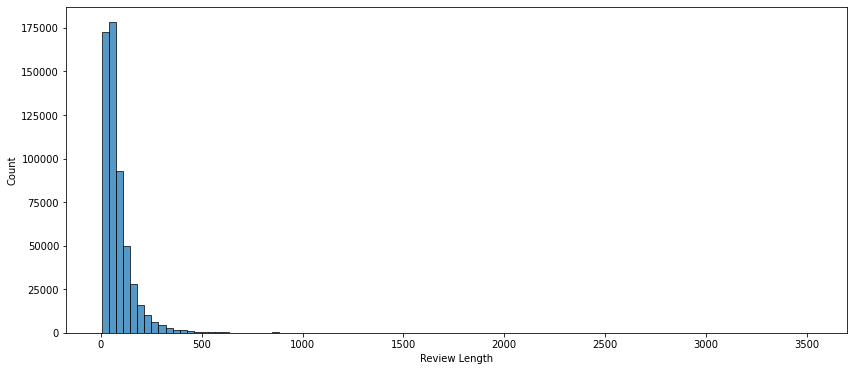

In [12]:
#words per review
plt.figure(figsize = (14,6))
WordsPerReview = data['Text'].apply(lambda x: len(x.split(' ')))

sns.histplot(WordsPerReview,bins = 100)

plt.xlabel('Review Length')
plt.show()

## Build word count vector for each review

### Define what's a positive and negative sentiment

In [126]:
# ignore all 3* reviews
products = products[products['Score'] != 3]

# positive sentiment = 4* or 5* reviews
products['Sentiment'] = (products['Score'] >=4) * 1

products.head()

,ProductId,Score,Text,Sentiment
0,B001E4KFG0,5,I have bought several of the Vitality canned d...,1
1,B00813GRG4,1,Product arrived labeled as Jumbo Salted Peanut...,0
2,B000LQOCH0,4,This is a confection that has been around a fe...,1
3,B000UA0QIQ,2,If you are looking for the secret ingredient i...,0
4,B006K2ZZ7K,5,Great taffy at a great price. There was a wid...,1


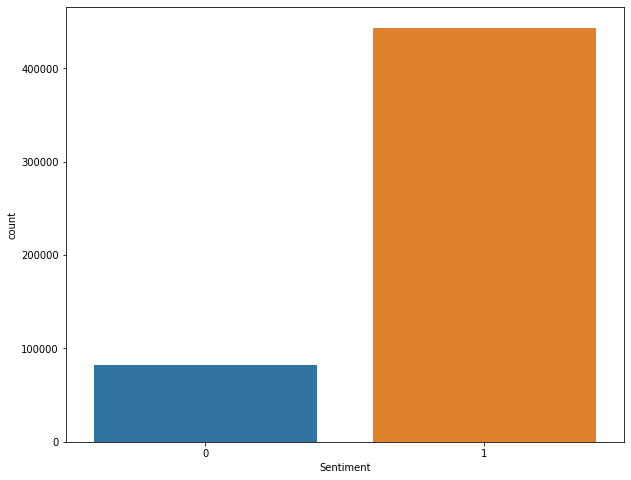

In [127]:
plt.figure(figsize = ( 10,8))
sns.countplot(data = products, x = 'Sentiment')
plt.show()

## Explore most frequent product

In [128]:
data["ProductId"].describe()
print(data.groupby(['ProductId'])['ProductId'].agg(['count']).sort_values(by='count', ascending=False))

            count
ProductId        
B007JFMH8M    913
B0026RQTGE    632
B002QWP8H0    632
B002QWHJOU    632
B002QWP89S    632
...           ...
B000YPQC08      1
B003YU5T6I      1
B000YPQC44      1
B000YPQE6U      1
B009WVB40S      1

[74258 rows x 1 columns]


In [129]:
# product B007JFMH8M is the most popular one based on the number of reviews
# it refers for "GREENIES Weight Management Dental Regular"

greenies_reviews = data[data['ProductId'] == 'B007JFMH8M']
print(greenies_reviews.groupby(['Score'])['Score'].agg(['count']).sort_values(by='count', ascending=False))

       count
Score       
5        624
4        217
3         56
2         12
1          4


## Analysing the data

Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot Word Clouds for Positive and Negative tweets from our dataset and see which words occur the most.

#### Word-Cloud for Negative reviews.

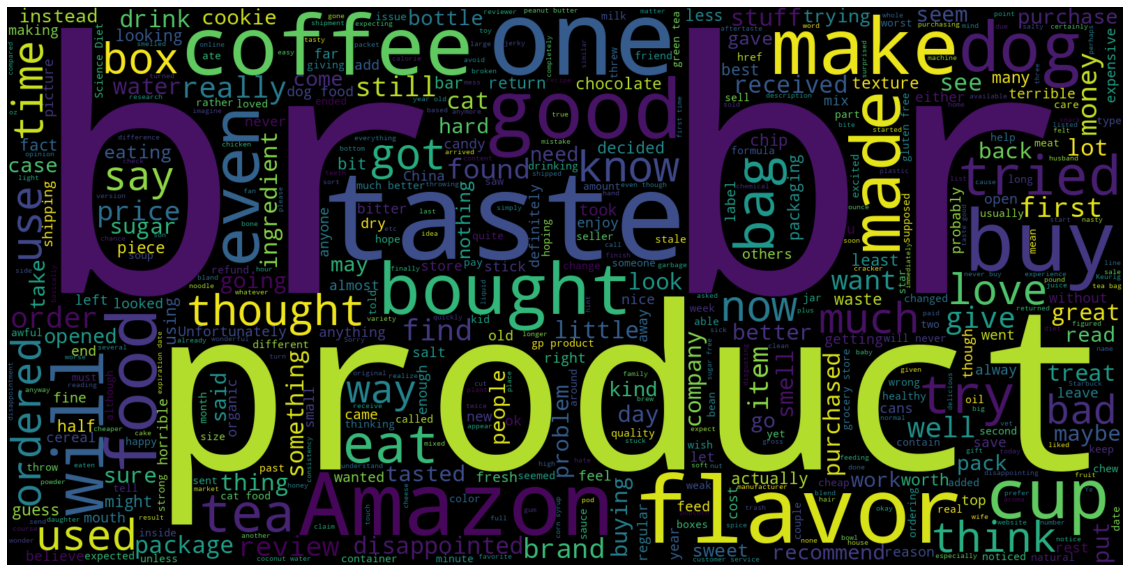

In [130]:
neg_reviews = products[products["Sentiment"] == 0]

# concat all reviews into one sentence
txt = ' '.join(review for review in neg_reviews.Text)

wordcloud = WordCloud(
            max_font_size = 500,
            max_words = 500,
            width = 1600, 
            height = 800
            ).generate(txt)

plt.figure(figsize = (20,20))

plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Word-Cloud for Positive reviews.

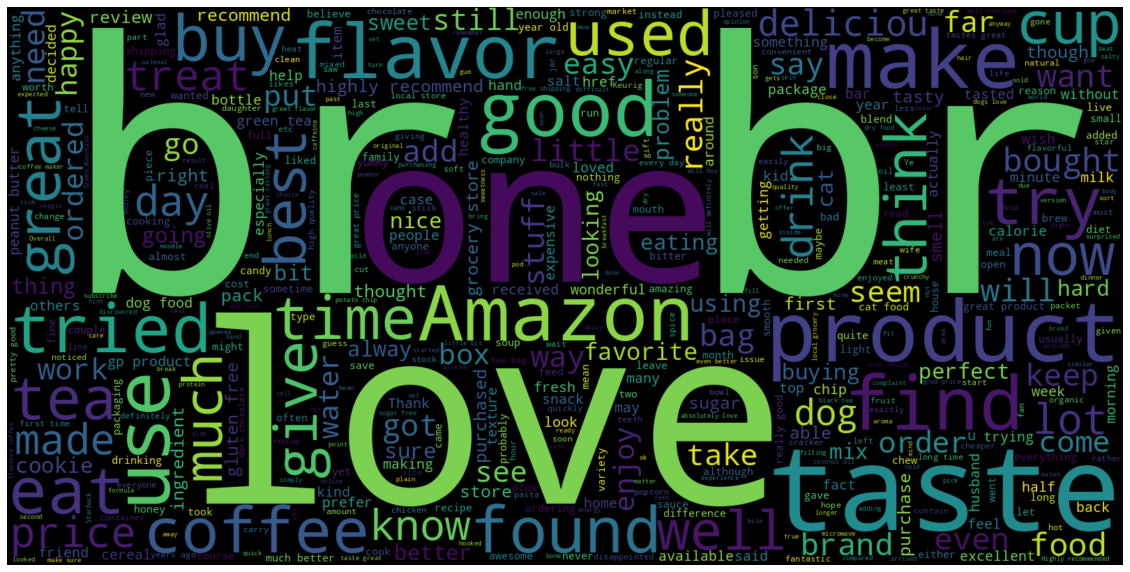

In [131]:
pos_reviews = products[products["Sentiment"] == 1]

# concat all reviews into one sentence
txt = ' '.join(review for review in pos_reviews.Text)

wordcloud = WordCloud(
            max_font_size = 500,
            max_words = 500,
            width = 1600, 
            height = 800
            ).generate(txt)

plt.figure(figsize = (20,20))

plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Preprocess Text

<b>Text Preprocessing</b> is traditionally an important step for <b>Natural Language Processing (NLP)</b> tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.


<b>The Preprocessing steps taken are:</b>
1. <b>Lower Casing:</b> Each text is converted to lowercase.
2. <b>Replacing URLs:</b> Links starting with "http" or "https" or "www" are replaced by "URL".
3. <b>Replacing Emojis:</b> Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
4. <b>Replacing Usernames:</b> Replace @Usernames with word "<b>USER</b>". (eg: "@Kaggle" to "USER")
5. <b>Removing Non-Alphabets:</b> Replacing characters except Digits and Alphabets with a space.
6. <b>Removing Consecutive letters:</b> 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
7. <b>Removing Short Words:</b> Words with length less than 2 are removed.
8. <b>Removing Stopwords:</b> Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
9. <b>Lemmatizing:</b> Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

In [132]:
def clean_text(text):
   
    text = str(text).lower() # normalizing text
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text) # Removing Unicode Characters (URLs, Emojis, Usernames ...)
    
    return text

In [133]:
products['Text'] = products['Text'].apply(clean_text)
products.head()

,ProductId,Score,Text,Sentiment
0,B001E4KFG0,5,i have bought several of the vitality canned d...,1
1,B00813GRG4,1,product arrived labeled as jumbo salted peanut...,0
2,B000LQOCH0,4,this is a confection that has been around a fe...,1
3,B000UA0QIQ,2,if you are looking for the secret ingredient i...,0
4,B006K2ZZ7K,5,great taffy at a great price there was a wide...,1


### Process Review's text and remove stop words

In [141]:
# Using spaCy ad NLP tool 
nlp = English()

# Defining set containing all stopwords in english.
stopwords = nlp.Defaults.stop_words

print(len(stopwords))
print(stopwords)

326
{'into', 'could', 'further', 'become', 'those', 'thereupon', 'used', 'beside', 'this', 'throughout', 'per', 'were', 'itself', 'off', '’re', "'ll", 'a', 'something', 'when', 'due', '‘ll', 'various', 'everything', 'show', 'thence', 'rather', 'but', 'and', 'so', 'well', 'anywhere', 'again', 'twenty', 'regarding', '’ve', 'via', '’s', 'keep', 'along', 'yet', "n't", 'ca', 'not', 'onto', 'nor', 'before', 'less', 'between', 'any', 'somehow', 'more', 'up', '‘m', 'will', 'has', 'he', 'back', 'our', 'say', 'thereby', 'it', 're', 'forty', 'everyone', 'even', 'n‘t', 'being', 'five', 'if', 'whether', 'thru', 'therein', 'hers', 'we', 'most', 'of', 'against', 'both', 'through', 'how', 'sometime', 'becomes', 'made', 'whoever', 'though', 'over', 'anyway', 'always', 'seeming', 'wherever', 'may', 'whole', 'its', 'upon', 'whatever', 'next', "'s", 'i', 'whereafter', 'you', 'whereby', 'as', 'full', 'does', 'seemed', 'top', 'she', 'enough', 'first', 'her', 'which', 'see', 'done', 'they', 'front', 'to', 'o

In [135]:
# Remove stop words from review
def remove_stopword(stop_words, sentence):
    doc = nlp(sentence)
    result = ""
    for word in doc:
         if not word.is_stop:
            result += word.text + " "
    return result.strip()

processed_text = remove_stopword(stopwords, products.iloc[0]['Text'])

# Example of processed review
print("Original text : " + products.iloc[0]['Text'])
print("=========")
print("Text after removing stopwords : " + processed_text)

Original text : i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than  most
Text after removing stopwords : bought vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better


In [136]:
# Updating all reviews
products['Text'] = products['Text'].apply(lambda row: remove_stopword(stopwords, row))
products

,ProductId,Score,Text,Sentiment
0,B001E4KFG0,5,bought vitality canned dog food products found...,1
1,B00813GRG4,1,product arrived labeled jumbo salted peanutsth...,0
2,B000LQOCH0,4,confection centuries light pillowy citrus ge...,1
3,B000UA0QIQ,2,looking secret ingredient robitussin believe f...,0
4,B006K2ZZ7K,5,great taffy great price wide assortment yumm...,1
...,...,...,...,...
568449,B001EO7N10,5,great sesame chickenthis good better resturant...,1
568450,B003S1WTCU,2,m disappointed flavor chocolate notes especial...,0
568451,B004I613EE,5,stars small 1015 training session tried trai...,1
568452,B004I613EE,5,best treats training rewarding dog good groomi...,1


## Build the sentiment classifier

We are going to use <b>Bernoulli Naive Bayes</b> as our main algoritnm for classification.

In [137]:
# Split the dataset into tain and test sets
X = products['Text']
y = products['Sentiment']


X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 42,
                                                   test_size = 0.20)
X_train.shape,X_test.shape,y_train.shape, y_test.shape

((420618,), (105155,), (420618,), (105155,))

## Let's train the classifier

In [138]:
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
    ])

fit_model = clf.fit(X_train,y_train)


### Let's Evaluate our model

In [139]:
print('Training accuracy:', fit_model.score(X_train,y_train))
print('Test accuracy:', fit_model.score(X_test,y_test))

Training accuracy: 0.8638978835903361
Test accuracy: 0.858913033141553


              precision    recall  f1-score   support

           0       0.96      0.10      0.17     16346
           1       0.86      1.00      0.92     88809

    accuracy                           0.86    105155
   macro avg       0.91      0.55      0.55    105155
weighted avg       0.87      0.86      0.81    105155



Text(0.5, 1.0, 'Confusion Matrix')

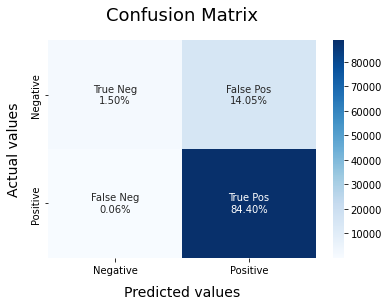

In [152]:
# Predict values for Test dataset
y_pred = fit_model.predict(X_test)

# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
            xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Apply the learned model to predict the sentiment for my review

In [169]:
text = "This is a bad product, i made a terrible mistake by spending my money on it"

my_review_text = [text]

predicted = fit_model.predict(my_review_text)

print("Most likely the user with this review:") 
print("liked" if predicted else "disliked" + " this product")

Most likely the user with this review:
disliked this product


------------------------------
Thank you for reading, till next time :)